# Ensemble

Esse notebook irá realizar a avaliação dos modelos já treinos, o treino do Ensemble, e a avaliação final de teste.

In [135]:
import pickle
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sqlalchemy import create_engine

import wandb
from wandb.keras import WandbCallback

# Carrega os modelos

Começamos carregando os modelos finais escolhidos

## Redes neurais

Os modelos de redes neurais escolhidos foram:

- larger_reg3_longer: Melhor de todos (possuia a melhor métrica na última epoch, considerando a versão não treinada por mais tempo)
- ag_best: Melhor selecionado pelo AG
- larger_ag_both_1006_982_1.0_0.00689_0.14732_0.25017_week: Melhor na melhor epoch
- lstm3_longer: Melhor LSTM (possuia a melhor métrica na última epoch, considerando a versão não treinada por mais tempo)

In [ ]:
# Carrega os modelos

names = ["ag_best", "larger_reg3_longer", "ag_both", "lstm3_longer"]

models = {}

for name in names:
    path = name+".h5"
    models[name] = keras.models.load_model(path)

## Regressões polinomiais

Os modelos de regressão escolhidos foram os três treinados:  
- regressão linear 
- polinomial de grau 2  
- polinomial de grau 3

In [3]:
# Carrega os modelos

for name in ["lr", "pol2", "pol3"]:
    file = open(name, "rb")
    models[name] = pickle.load(file)
    file.close()

In [37]:
tf_keras_names = names
sklearn_names = ["lr", "pol2", "pol3"]

# Carrega os dados

Aqui carregamos o dataset para o ensemble

In [10]:
# Pasta em que estão armazenados os dados, alterar para o local apropriado

dataset_folder = "..\\data"

In [13]:
# Carrega os dados

file = open(dataset_folder+"\\ens_train_df", 'rb')
train_df = pickle.load(file)
file.close()

file = open(dataset_folder+"\\ens_val_df", 'rb')
val_df = pickle.load(file)
file.close()

file = open(dataset_folder+"\\info.json", 'r')
info_dict = json.load(file)
file.close()

In [14]:
# Prepara a engine SQL e a lista de features

features_names = info_dict["feature_names"]
engine = create_engine("sqlite://", echo=False)

In [15]:
# Aglomera os dados de treino por semana

engine.execute("DROP TABLE IF EXISTS Clima_Casos")

train_df.to_sql("Clima_Casos", con=engine)
query = "SELECT Nome_municipio, Sum(Precipitacao) as Precipitacao, Avg(Pressao_at_max) as Pressao_at_max, "
query += "Avg(Pressao_at_min) as Pressao_at_min, Avg(Radiacao) as Radiacao, Avg(Temp_max) as Temp_max, Avg(Temp_min) as Temp_min, "
query += "Avg(Umidade) as Umidade, Avg(Max_vent) as Max_vent, Avg(Velocidade_vent) as Velocidade_vent, Pop_estimada, "
query += " DIA/7 AS Semana, Sum(Casos) as Casos FROM Clima_Casos GROUP BY Nome_municipio, Semana"

train_df_week = pd.read_sql_query(query, engine)

In [16]:
# Aglomera os dados de validação por semana

engine.execute("DROP TABLE IF EXISTS Clima_Casos")

val_df.to_sql("Clima_Casos", con=engine)
query = "SELECT Nome_municipio, Sum(Precipitacao) as Precipitacao, Avg(Pressao_at_max) as Pressao_at_max, "
query += "Avg(Pressao_at_min) as Pressao_at_min, Avg(Radiacao) as Radiacao, Avg(Temp_max) as Temp_max, Avg(Temp_min) as Temp_min, "
query += "Avg(Umidade) as Umidade, Avg(Max_vent) as Max_vent, Avg(Velocidade_vent) as Velocidade_vent, Pop_estimada, "
query += " DIA/7 AS Semana, Sum(Casos) as Casos FROM Clima_Casos GROUP BY Nome_municipio, Semana"

val_df_week = pd.read_sql_query(query, engine)

## Formata para os modelos baseados em redes neurais

- Separa as features e o target
- Normaliza os dados

In [ ]:
# Remove as colunas não features da lista

features_names.remove("Dia")
features_names.remove("Nome_municipio")

In [101]:
# Separa as features e o target

train_features = train_df_week[features_names]
val_features = val_df_week[features_names]

train_target = train_df_week["Casos"]
val_target = val_df_week["Casos"]

In [32]:
# Carrega as distribuições para realizar a normalização

file = open("train_dist_week.json", "r")
train_dist = json.load(file)
file.close()

file = open("target_dist_week.json", "r")
target_dist = json.load(file)
file.close()

OBS: a gente percebeu apenas após os treinos que o target não é normalizado, nem neste notebook, nem no notebook principal de treino dos modelos

In [107]:
# Normaliza os dados

for df in [train_features, val_features]:
    for column in train_features:
        df.loc[:, column] = (df[column]-train_dist[column]["mean"])/train_dist[column]["std"]

for df in [train_target, val_target]:
    df = (df-target_dist["mean"])/target_dist["std"]


C:\Python38\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Formata para os modelos baseados em regressão polinomial

- Calcula a quantidade de casos pela população
- Separa as features e o target

In [34]:
# Calcula os casos/população

train_df_week['Casos_pela_pop'] = train_df_week['Casos'] / train_df_week['Pop_estimada']
val_df_week['Casos_pela_pop'] = val_df_week['Casos'] / val_df_week['Pop_estimada']

In [35]:
# Define as features e o target

feat_x = [
 'Precipitacao',
 'Pressao_at_max',
 'Pressao_at_min',
 'Radiacao',
 'Temp_max',
 'Temp_min',
 'Umidade',
 'Max_vent',
 'Velocidade_vent'
 ]
feat_y = ['Casos_pela_pop']

In [36]:
# Separa as features e o target

train_features_sklearn = train_df_week[feat_x]
train_target_sklearn = train_df_week[feat_y]

val_features_sklearn = val_df_week[feat_x]
val_target_sklearn = val_df_week[feat_y]

# Realiza as predições

Realiza as predições com os modelos para utilizar no treino do ensemble. Realiza as conversões necessárias (casos/população -> casos)

In [69]:
# Array de predições

train_predictions = np.empty((len(models), train_features.shape[0]), dtype=np.float64)

In [81]:
i = 0

# Predições com as redes neurais
for name in tf_keras_names:
    train_predictions[i] = models[name].predict(train_features).flatten()
    
    i += 1

# Predições com as regressões. Também converte casos/população para casos.
for name in sklearn_names:
    train_predictions[i] = models[name].predict(train_features_sklearn)

    train_predictions[i] *= train_df_week["Pop_estimada"].to_numpy()

    i += 1

train_predictions = train_predictions.T

Realiza o mesmo processo com os dados de validação

In [82]:
val_predictions = np.empty((len(models), val_features.shape[0]), dtype=np.float64)

In [83]:
i = 0

for name in tf_keras_names:
    val_predictions[i] = models[name].predict(val_features).flatten()
    
    i += 1

for name in sklearn_names:
    val_predictions[i] = models[name].predict(val_features_sklearn)

    val_predictions[i] *= val_df_week["Pop_estimada"].to_numpy()

    i += 1

val_predictions = val_predictions.T

Mostra o resultado para uma cidade específica (São Paulo)

(-10.0, 100.0)

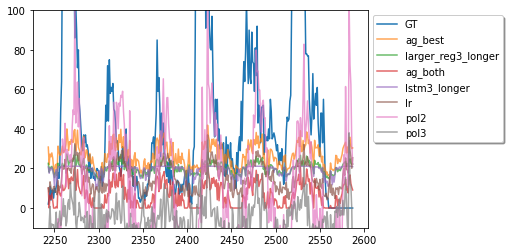

In [211]:
mask = train_df_week["Nome_municipio"] == "sao paulo"

weeks = train_df_week["Semana"][mask]
predictions_sp = train_predictions[mask]
gt = train_target[mask]

plt.plot(weeks, gt)
plt.plot(weeks, predictions_sp, alpha=0.7)
plt.legend(["GT"]+list(models.keys()), bbox_to_anchor=(1,1), fancybox=True, shadow=True)
plt.ylim(-10,100)

# Infraestrutura de treino

Prepara as estruturas necessárias para o treino do ensemble

In [125]:
BATCH_SIZE = train_df.shape[0]//6

In [136]:
from typing import Dict

class ModelManager:
    '''
        Gerencia os modelos criados
    '''

    def __init__(self, project_name, train_features, train_target, val_features, val_target, save_dir="."):
        '''
            Construtor do ModelManager.

            Parâmetros:
                project_name: Nome do projeto. Utilizado para logar no wandb.
                train_features: Features do conjunto de treino.
                train_target: Coluna objetivo do conjunto de treino.
                val_features: Features do conjunto de validação.
                val_target: Coluna objetivo do conjunto de validação.
                save_dir: Diretório para salvar os modelos.
        
        '''
        self._project_name = project_name

        self._save_dir = save_dir
        self._model_save_dir = self._save_dir+"\\models"
        self._log_dir = self._save_dir+"\\log"
        
        self._models : Dict[str, keras.Model] = {}
        self._current_model = ""

        self._architectures = {}
        self._hist = {}

        self._data = {}
        self._data["train_features"] = np.asarray(train_features)
        self._data["train_target"] = np.asarray(train_target)
        self._data["val_features"] = np.asarray(val_features)
        self._data["val_target"] = np.asarray(val_target)

        self._sample_features = self._data["train_features"][:10000]
        self._sample_target = self._data["train_target"][:10000]
        self._sample_x = train_df["Dia"][:10000]

    def set_sample(self, sample_features, sample_target, sample_x):
        '''
            Define os dados para plotar o gráfico exemplo.

            Parâmetros:
                sample_features: Features para plotar o gráfico.
                sapmle_target: Ground truth
                sample_x: Dados para utilizar no eixo x do gráfico.
        '''
        self._sample_features = sample_features
        self._sample_target = sample_target
        self._sample_x = sample_x

    def register_model(self, model, model_name, architecture_name):
        '''
            Registra um modelo para ser treinado.

            Parâmetros:
                model: Modelo a ser treinado.
                model_name: Nome do modelo.
                architecture_name: Nome da arquitetura que o modelo utiliza.
        '''

        self._current_model = model_name

        self._models[model_name] = model
        self._architectures[model_name] = architecture_name

    def compile_fit_save(self, epochs, optimizer, model_name=None, batch_size=BATCH_SIZE, patience=None, verbose='auto', loss="mean_squared_error", group=None):
        '''
            Compila, treina e salva o modelo.

            Parâmetros:
                epochs: Quantidade de epochs que o modelo será treinado.
                optimizer: Otimizador que será utilizado.
                model_name: Nome do modelo que será treinado. None treina o último modelo registrado.
                batch_size: Tamanho do batch.
                patience: Paciência do treino. None treina o modelo até a última epoch.
                verbose: Verbose do treino.
                loss: Função de perda utilizada para o treino.
                group: Nome do grupo do modelo (utilizado pelo wandb).
        '''
        
        if model_name is None:
            model_name = self._current_model
        else:
            self._current_model = model_name

        learning_rate = optimizer.learning_rate.numpy()
        
        config = {}
        config["leaning_rate"] = learning_rate
        config["epochs"] = epochs
        config["architecture"] = self._architectures[model_name]
        config["batch_size"] = batch_size
        config["optimizer"] = optimizer._name
        config["loss"] = loss
        config["patience"] = patience

        run = wandb.init(project=self._project_name, entity="breath",
                           config = config, group=group)
        
        run.name = model_name

        metrics = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error]

        model = self._models[model_name]
        model.compile(optimizer=optimizer, 
                        loss= tf.keras.losses.get(loss),
                        metrics=metrics)
        
        callbacks = []
        callbacks.append(WandbCallback("val_mean_squared_error" ))
        #callbacks.append(keras.callbacks.TensorBoard(log_dir=self._log_dir, histogram_freq=1))
        
        if patience is not None:
            callbacks.append(keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=patience))

        self._hist[model_name] = model.fit(x=self._data["train_features"], y=self._data["train_target"], 
                                    validation_data=(self._data["val_features"], self._data["val_target"]),
                                    epochs=epochs, batch_size=batch_size,
                                    callbacks= callbacks, verbose=verbose)

        
        self.plot_sample()
        wandb.log({"predictions":plt})
        plt.show()

        wandb.finish()

    def plot_sample(self, show=False):
        '''
            Plota o modelo atual com os dados de exemplo.

            Parâmetros:
                show: Se o gráfico deverá ser mostrado na tela.
        '''
        model  = self._models[self._current_model]

        predictions = model.predict(self._sample_features).flatten()
        plt.plot(self._sample_x, self._sample_target)
        plt.plot(self._sample_x, predictions)
        plt.ylabel("Casos/População")
        plt.legend(["GT", "Predito"])

        if show:
            plt.show()


    def save(self, model_name):
        '''
            Salva um modelo.

            Parâmetros:
                model_name: Nome do modelo que vai ser salvo.
        '''
        self._models[model_name].save(self._model_save_dir+"\\"+model_name)

        try:
            keras.models.load_model(self._model_save_dir)
        except Exception as e:
            print(e)
            print("ERRO AO SALVAR O MODELO")
    
    def load(self, model_name):
        '''
            Carrega um modelo.

            Parâmetros:
                model_name: Nome do modelo que vai ser carregado.
        '''
        self._models[model_name] = keras.models.load_model(self._model_save_dir)

        self._current_model = model_name

In [140]:
# Define os dados de exemplo

index = np.argmax(val_df_week["Casos"])
municipio = val_df_week["Nome_municipio"].iloc[index]

mask = val_df_week["Nome_municipio"] == municipio
mask = mask.to_numpy()

features = val_predictions[mask]

manager = ModelManager("BReATH_Ensemble", train_predictions, train_target.to_numpy(), val_predictions, val_target.to_numpy(), save_dir=".\\save")
manager.set_sample(features, val_target[mask], val_df_week["Semana"][mask])

# Treino do Ensemble

Treina os modelos de ensemble.

1º Modelo - Regressão linear

In [141]:
def create_linear_ens():
    input = keras.Input(shape=(7), name="input")
    out = keras.layers.Dense(1, activation="linear", use_bias=True)(input)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_linear_ens()
manager.register_model(model, "linear_en", "linear_en")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=1000)

Segundo modelo - Uma camada densa

In [143]:
def create_one_layer_ens():
    input = keras.Input(shape=(7), name="input")
    x= keras.layers.Dense(100, activation="relu")(input)
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_one_layer_ens()
manager.register_model(model, "one_layer_en", "one_layer_en")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=2000, patience=100)

Camada maior

In [145]:
def create_one_layer_ens2():
    input = keras.Input(shape=(7), name="input")
    x= keras.layers.Dense(200, activation="relu")(input)
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_one_layer_ens2()
manager.register_model(model, "one_layer_ens2", "one_layer_ens2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=2000, patience=100)

Treina o modelo de uma camada por mais tempo

In [ ]:
model = create_one_layer_ens()
manager.register_model(model, "one_layer_ens", "one_layer_ens")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=2000)

Plotamos um gráfico de São Paulo para verificar a performance do modelo

(0.0, 100.0)

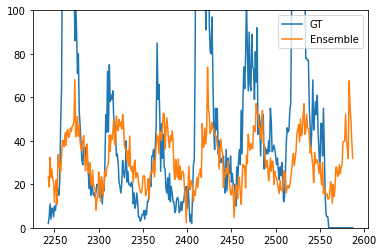

In [203]:
mask = train_df_week["Nome_municipio"] == "sao paulo"

weeks = train_df_week["Semana"][mask]
predictions_sp = train_predictions[mask]
gt = train_target[mask]

model = manager._models["linear_en"]

ens_prection = model.predict(predictions_sp)

plt.plot(weeks, gt)
plt.plot(weeks, ens_prection)
plt.legend(["GT", "Ensemble"])
plt.ylim(0,100)

Modelo com menos neurônios

In [156]:
def create_one_layer_ens3():
    input = keras.Input(shape=(7), name="input")
    x= keras.layers.Dense(50, activation="relu")(input)
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_one_layer_ens3()
manager.register_model(model, "one_layer_ens3", "one_layer_ens3")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=2000)

Aplicamos regularização para tentar diminuir o overfitting

In [158]:
def create_one_layer_ens_reg():
    input = keras.Input(shape=(7), name="input")
    x = keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(0.05) )(input)
    x = keras.layers.Dropout(0.2)(x)
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [159]:
model = create_one_layer_ens3()
manager.register_model(model, "one_layer_ens_reg", "one_layer_ens_reg")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=2000)

Epoch 1/2000
1/1 [==============================] - 1s 559ms/step - loss: 53.2044 - mean_absolute_error: 0.4054 - mean_squared_error: 53.2044 - val_loss: 0.7807 - val_mean_absolute_error: 0.1597 - val_mean_squared_error: 0.7807
Epoch 2/2000
1/1 [==============================] - 0s 21ms/step - loss: 52.9978 - mean_absolute_error: 0.4081 - mean_squared_error: 52.9978 - val_loss: 0.7763 - val_mean_absolute_error: 0.1649 - val_mean_squared_error: 0.7763
Epoch 3/2000
1/1 [==============================] - 0s 23ms/step - loss: 52.7500 - mean_absolute_error: 0.4112 - mean_squared_error: 52.7500 - val_loss: 0.7721 - val_mean_absolute_error: 0.1705 - val_mean_squared_error: 0.7721
Epoch 4/2000
1/1 [==============================] - 0s 22ms/step - loss: 52.4716 - mean_absolute_error: 0.4142 - mean_squared_error: 52.4716 - val_loss: 0.7681 - val_mean_absolute_error: 0.1762 - val_mean_squared_error: 0.7681
Epoch 5/2000
1/1 [==============================] - 0s 22ms/step - loss: 52.1699 - mean_abs

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,▅█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,▁▅██▇▆▅▄▄▄▄▄▄▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
val_mean_absolute_error,▄█▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▅██▇▆▅▄▄▄▄▄▄▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
best_epoch,18
best_val_mean_squared_error,0.73567
epoch,1999
loss,22.17753


Verificando as métricas, determinamos que a regressão linear foi o modelo com maior performance (menor métrica de validação). Mais uma vez, todos os modelos tiveram métricas de treino e validação muito distantes, com a métrica de validação sendo consideravelmente menor.

In [169]:
ens_best_model = manager._models["linear_en"]

# Avaliação

Vamos realizar a avaliação de todos os modelos para determinar o melhor modelo.

In [192]:
scores = {}

In [ ]:
# Calcula o score dos modelos no conjunto de validação

scores["val"] = {}

i = 0
for name in models:
    scores["val"][name] = keras.losses.mean_squared_error(val_target, val_predictions[:,i]).numpy()
    i += 1

ens_predictions = ens_best_model.predict(val_predictions).flatten()

scores["val"]["ensemble"] = keras.losses.mean_squared_error(val_target, ens_predictions.flatten()).numpy()

In [195]:
# Calcula o score dos modelos no conjunto de treino

scores["train"] = {}

i = 0
for name in models:
    scores["train"][name] = keras.losses.mean_squared_error(train_target, train_predictions[:,i]).numpy()
    i += 1

ens_predictions = ens_best_model.predict(train_predictions).flatten()

scores["train"]["ensemble"] = keras.losses.mean_squared_error(train_target, ens_predictions.flatten()).numpy()

In [250]:
# Prepara os dados

df = pd.DataFrame(scores)
df.sort_values("val")

names = df.index.to_numpy()

train_scores = df["train"].to_numpy()
val_scores = df["val"].to_numpy()

train_scores /= train_scores.max()
val_scores /= val_scores.max()

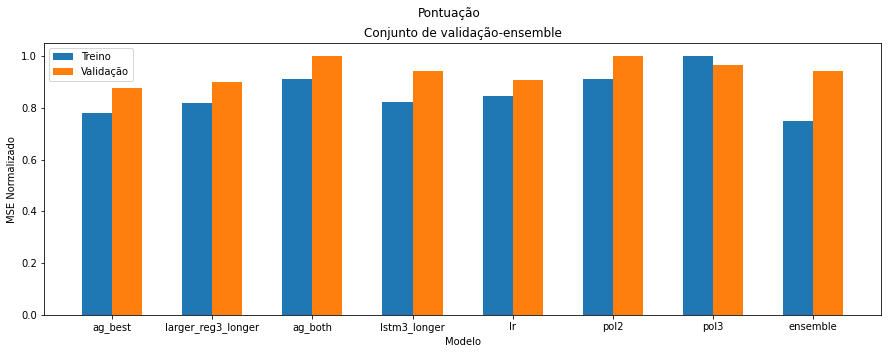

In [254]:
# Plota os scores

plt.figure(figsize=(15, 5))
plt.bar(np.arange(0,8,1)-0.3, train_scores, 0.3)
plt.bar(np.arange(0,8,1), val_scores, 0.3)

plt.xticks(np.arange(0,8,1)-0.15, names)

plt.legend(["Treino", "Validação"])

plt.xlabel("Modelo")
plt.ylabel("MSE Normalizado")

plt.suptitle("Pontuação")
plt.title("Conjunto de validação-ensemble")

plt.savefig("Pontuação.jpg")

Observando o gráfico, podemos verificar que, mesmo não sendo treinado nesse conjunto, o modelo ag_best teve métrica de treino semelhante, e métrica de validação menor que o ensemble, mostrando sua capacidade de generalização. Decidimos então utilizar esse modelo como o melhor modelo.

## Teste

Por fim, calculamos a métrica do melhor modelo no conjunto de teste.

In [212]:
# Carrega o conjunto

file = open(dataset_folder+"\\test_df", 'rb')
test_df = pickle.load(file)
file.close()

In [256]:
# Agrupa os dados por semana

engine.execute("DROP TABLE IF EXISTS Clima_Casos")

test_df.to_sql("Clima_Casos", con=engine)
query = "SELECT Nome_municipio, Sum(Precipitacao) as Precipitacao, Avg(Pressao_at_max) as Pressao_at_max, "
query += "Avg(Pressao_at_min) as Pressao_at_min, Avg(Radiacao) as Radiacao, Avg(Temp_max) as Temp_max, Avg(Temp_min) as Temp_min, "
query += "Avg(Umidade) as Umidade, Avg(Max_vent) as Max_vent, Avg(Velocidade_vent) as Velocidade_vent, Pop_estimada, "
query += " DIA/7 AS Semana, Sum(Casos) as Casos FROM Clima_Casos GROUP BY Nome_municipio, Semana"

test_df_week = pd.read_sql_query(query, engine)

In [271]:
# Separa as features e o target

test_features = test_df_week[features_names]
test_target = test_df_week["Casos"]

OBS: mais uma vez, não reparamos que não estávamos de fato normalizando o target.

In [272]:
# Normaliza os dados.

for df in [test_features]:
    for column in train_features:
        df.loc[:, column] = (df[column]-train_dist[column]["mean"])/train_dist[column]["std"]

for df in [test_target]:
    df = (df-target_dist["mean"])/target_dist["std"]


C:\Python38\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Calcula as métricas

MSE: 0,0736
MAN: 0,0598

MSE = 0.0736

In [273]:
test_predictions = models["ag_best"].predict(test_features).flatten()

Plotamos o erro do modelo

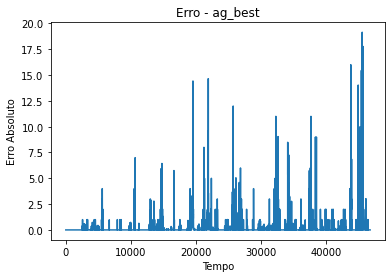

In [297]:
# Plota o erro do modelo

plt.plot(np.abs(test_target-test_predictions))
plt.ylabel("Erro Absoluto")
plt.xlabel("Tempo")
plt.title("Erro - ag_best")
plt.savefig("Erro.jpg")

In [283]:
scores["test"] = keras.losses.mean_squared_error(test_target, test_predictions).numpy()

scores["test"]

0.29765308

## Exportação

Por fim, exportamos as métricas.

In [295]:
scores2 = {}
for key in scores:
    if isinstance(scores[key], dict):
        scores2[key] = {}
        for key2 in scores[key]:
           scores2[key][key2] = float(scores[key][key2])
    else:
        scores2[key] = float(scores[key])

In [296]:
file = open("scores.json", "w")
json.dump(scores2, file)
file.close()